In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import ompy as om

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Validate `om.Extractor.decompose`

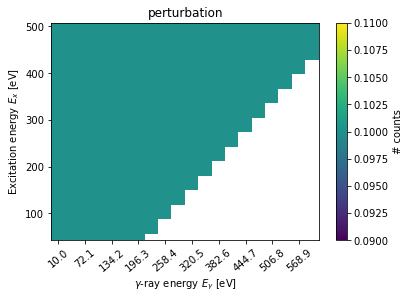

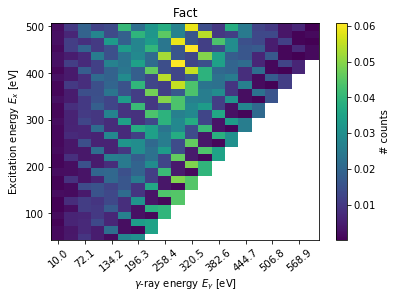

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 10885


NameError: name 'mat_f' is not defined

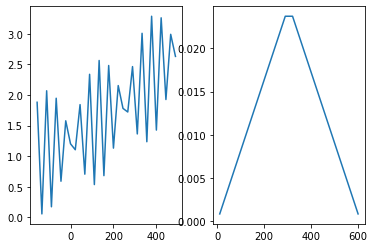

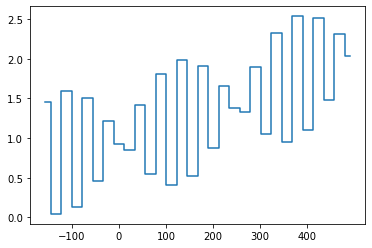

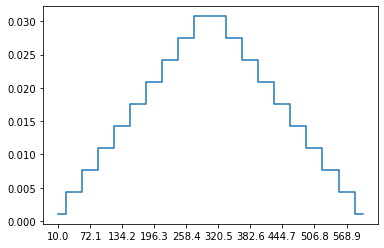

In [81]:
N, M = 30, 20
Ex = np.linspace(50, 500, N)
Eg = np.linspace(10, 600, M)
res = om.diagonal_resolution(Ex)
Enld = np.linspace(-res.max(), Ex.max()-Eg.min(), N)
nld = np.exp(np.linspace(0, 1, N)) + np.sin(Enld)
gsf = Eg**1/2/Eg.sum()
gsf[(M//2):] = gsf[:(M//2)][::-1]

mat = om.nld_gsf_product(nld, gsf, res, Enld, Eg, Ex)
fact = om.Matrix(values=mat, Ex=Ex, Eg=Eg)
std = np.zeros_like(mat, dtype=float)
std[mat > 0] = 0.1*np.ones_like(std[mat>0])#np.random.random(std[mat > 0].shape)
err = om.Matrix(values=std, Ex=Ex, Eg=Eg)
err.plot(title='perturbation')
fact.plot(title='Fact')
fig, ax = plt.subplots(ncols=2)
ax[0].plot(Enld, nld)
ax[1].plot(Eg, gsf)

perturbed = om.Matrix(values=fact.values, Ex=Ex, Eg=Eg)
extractor = om.Extractor()
nld_f, gsf_f = extractor.decompose(perturbed)
nld_f.plot()
gsf_f.plot()
G = om.Matrix(values=mat_f, Ex=Ex, Eg=Eg)
G.plot()
F = om.Matrix(values=(mat_f-fact.values)/fact.values, Ex=Ex, Eg=Eg)
F.plot(title="Relative error", scale='linear')

# Singular Value Decomposition as alternative? 

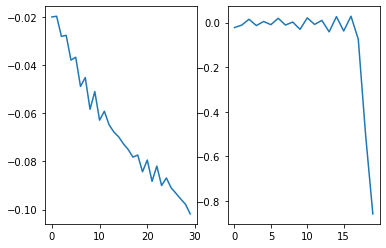

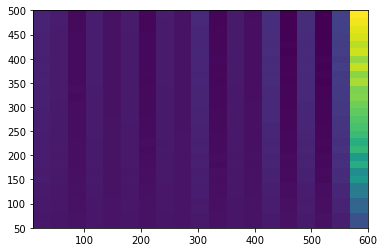

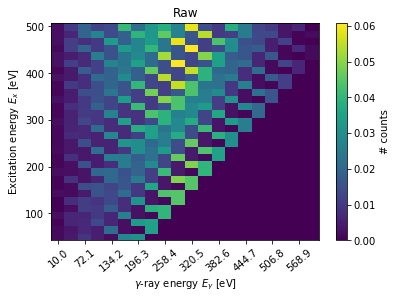

(<matplotlib.collections.QuadMesh at 0x7fb54efb3450>,
 <Figure size 432x288 with 2 Axes>)

In [44]:
from scipy.linalg import svd, diagsvd
U, s, Vh = svd(fact.values)
S = diagsvd(s, *fact.shape)
u = s[0]*U[:, 0]
v = Vh[:, 0]
fig, ax = plt.subplots(ncols=2)
ax[0].plot(u)
ax[1].plot(v)
fig, ax = plt.subplots()
ax.pcolormesh(fact.Eg, fact.Ex, np.outer(u, v))
georg = om.Matrix(values=U@S@Vh, Eg=fact.Eg, Ex=fact.Ex)
georg.plot()

In [8]:
%%cython --annotate --force
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp
# cython: language_level=3
# cython: boundscheck=False
# cython: wraparound=False

cimport cython
cimport numpy as cnp
import numpy as np
from cython.parallel import prange

ctypedef cnp.float64_t DTYPE_t
DTYPE=np.float64

def chisquare(double[:, ::1] fact, double[:, ::1] fit,
              double[:, ::1] std):
    """ Computes χ² of two matrices

    """

    cdef double chi = 0.0
    cdef Py_ssize_t num_Eg = fact.shape[1]
    cdef Py_ssize_t num_Ex = fact.shape[0]
    cdef int i, j
    for i in range(num_Ex):#prange(num_Ex, nogil=True, schedule='static'):
        for j in range(num_Eg):
            if std[i, j] == 0:
                continue
            print(fact[i, j], fit[i, j], std[i, j])
            chi = chi + (fact[i, j] - fit[i, j])**2/std[i, j]**2
    return chi

# Using `Extractor.extract_from`

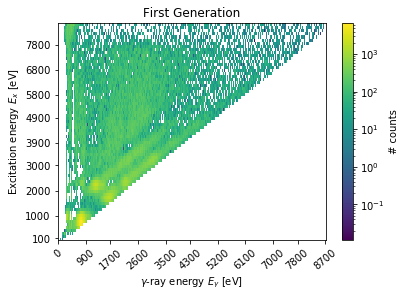

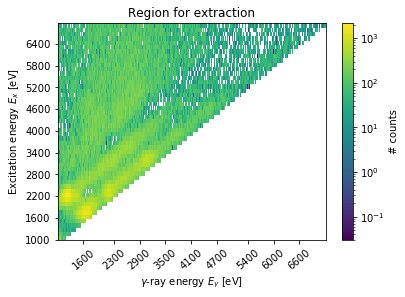

Optimization terminated successfully.
         Current function value: 88515426.392265
         Iterations: 3
         Function evaluations: 19073


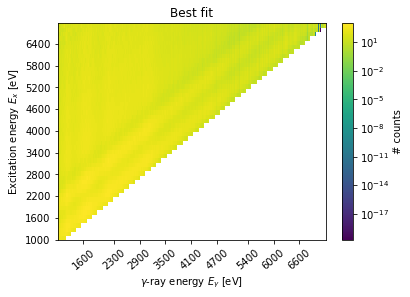

(<matplotlib.collections.QuadMesh at 0x7f078a663210>,
 <Figure size 432x288 with 2 Axes>)

In [17]:
dy164 = om.example_raw('Dy164')
response = om.example_response('dy164')

# Ensure that the dy164 has the same shape as the response
dy164.cut_diagonal()
dy164.cut_like(response)

# Use basic unfolding and first generation
unfolder = om.Unfolder(response=response)
unfolded = unfolder(dy164)
firstgen = om.FirstGeneration()
firstgend = firstgen(unfolded)
firstgend.plot(scale='log')

# Select the region we want to extract from
action = om.Action('matrix')
action.trapezoid(Ex_min=1000, Eg_min=1000, Ex_max=7000)
action.act_on(firstgend)
firstgend.plot(scale='log', title='Region for extraction')

extractor = om.Extractor()
extractor.trapezoid = action  # For ensemble extraction

nld, gsf, product = extractor.decompose(firstgend, product=True)
product.plot(scale='log', title='Best fit')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f078ef352d0>)

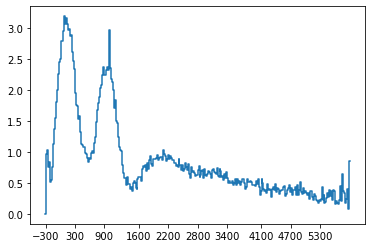

In [6]:
nld.plot()
gsf.plot()

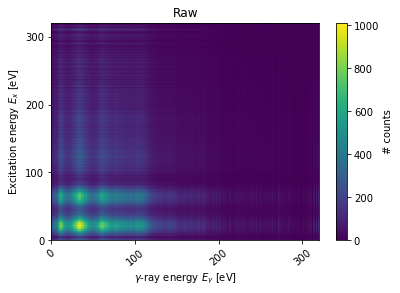

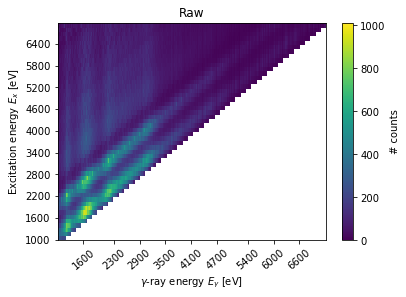

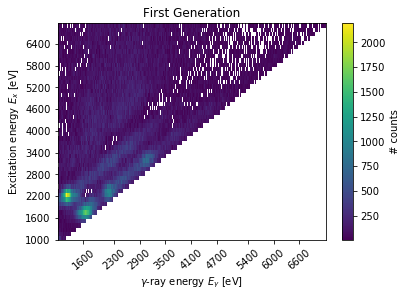

(<matplotlib.collections.QuadMesh at 0x7f56eb3c67d0>,
 <Figure size 432x288 with 2 Axes>)

In [46]:
mat = om.Matrix(np.outer(nld.values, gsf.values))
mat.plot(scale='linear')
product.plot(scale='linear')
firstgend.plot(scale='linear')

In [7]:
ensemble = om.Ensemble(dy164, save_path='ensemble_1')
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
ensemble.generate(10)

(<Figure size 432x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56f4edbd50>,
       dtype=object))

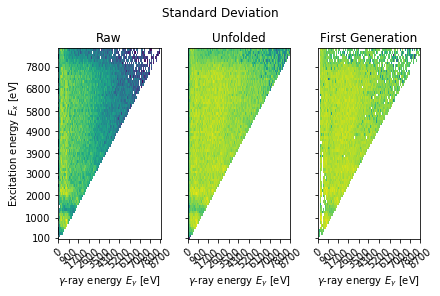

In [58]:
ensemble.plot()

In [8]:
extractor.extract_from(ensemble)

(0.1, 100.0)

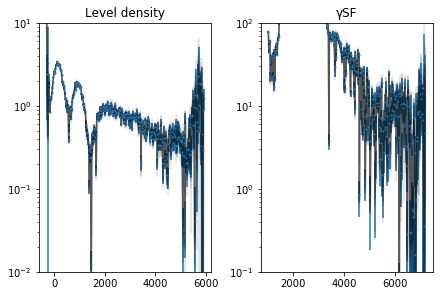

In [9]:
fig, ax = extractor.plot()
ax[0].set_ylim([1e-2, 1e1])
ax[1].set_ylim([1e-1, 1e2])

In [84]:
nld, gsf = extractor.nld[0], extractor.gsf[0]

IndexError: list index out of range

In [86]:
extractor.nld

[]

AssertionError: 

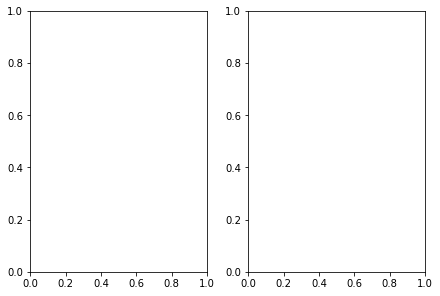

In [12]:
alpha = 2
A = 1
B = 10

nld, gsf = extractor.nld, extractor.gsf
for n in nld:
    n.E /= 1e3
for g in gsf:
    g.E /= 1e3
nld = [v.transform(alpha=alpha, const=A, inplace=False) for v in nld]
gsf = [v.transform(alpha=alpha, const=B, inplace=False) for v in gsf]
nld_mean = np.mean([v.values for v in nld])
gsf_mean = np.mean([v.values for v in gsf])
nld_std = np.std([v.values for v in nld])
gsf_std = np.std([v.values for v in gsf])

yscale ="log"
fig, (ax1,ax2) = plt.subplots(1, 2, constrained_layout=True) 
ax1.errorbar(nld[0].E, nld_mean, yerr=nld_std, fmt="o")
ax2.errorbar(gsf[0].E, gsf_mean, yerr=gsf_std, fmt="o")
ax1.set_yscale(yscale)
ax2.set_yscale(yscale)

ax1.set_ylabel(r"$\nld \,\, (\mathrm{MeV}^{-1})$")
ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

# Load and add published, normalized data:
ax1.legend(loc="best")
fig.suptitle("Chi-by-eye")
plt.show()